In [2]:
from sympy import MatrixSymbol, Matrix, Identity

import sympy as sym
import pandas as pd
import math

sym.init_printing()
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import control
import random

# IDENTIFICACIÓN DE SISTEMAS

Profesor: Jairo Alberto Cuéllar Guarnizo  
Programa: Ingeniería en Automatización y Control

## Ejemplo 1

Dada una señal de entrada y salida, obtenga el modelo estimado usando el modelo ARMAX.

In [6]:
## Sistema de segundo orden en tiempo continuo
tf = 7
dt = 0.1
g = control.tf([1],[1,1,5,3])
t = np.linspace(0,tf,int(tf/dt)+1)
A = 2
# Señal de salida ideal "y"
_,y = control.step_response(g,t)
N = len(t)
u = A*np.ones(N)
## Ruido para simular la señal de salida capturada "yn"
r = 0.02
e = np.random.normal(0,1,size=N)
yn = A*y+e*r

gd = control.c2d(g,dt)
print(gd)

#a = np.asarray([t,yn])
#a = a.transpose()
#np.savetxt('data\clase_09.csv', a, delimiter=",")

data = {'t':t,'yn':yn,'un':u}
df = pd.DataFrame(data)
df.to_csv('data\exercise_05.csv',index = False)


0.0001622 z^2 + 0.0006312 z + 0.0001543
---------------------------------------
  z^3 - 2.856 z^2 + 2.764 z - 0.9048

dt = 0.1



<AxesSubplot: xlabel='t', ylabel='un'>

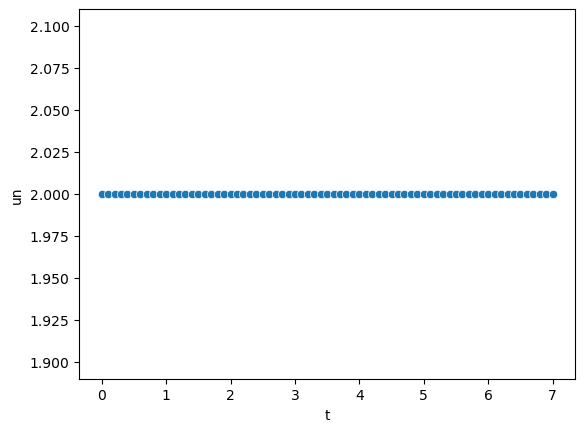

In [11]:
datos = pd.read_csv ('data\exercise_05.csv')
sns.scatterplot(datos,x ='t',y = 'un' )

In [17]:
# Datos a utilizar señales vk, ik, N (numero de muestras)
F = []
a = []
N = 100

# Variables necesarias para el proceso
Nk = []
V_p = I_p = P_p = k = 0;
# Se supone que Rv es desconocido, pero para garantizar que el ejercicio tenga coherencia
# debemos definirlo de forma aleatoria para luego simplemente decir que I=V/R
m = random.randrange(10,40);

for k in range(N):
    Nk.append(k+1)
    e1 = np.random.normal(0,0.02,size=1)
    a.append(random.randrange(-10,10)*(1+e1))
    e2 = np.random.normal(0,0.02,size=1)
    F.append((m*a[k])*(1+e2))


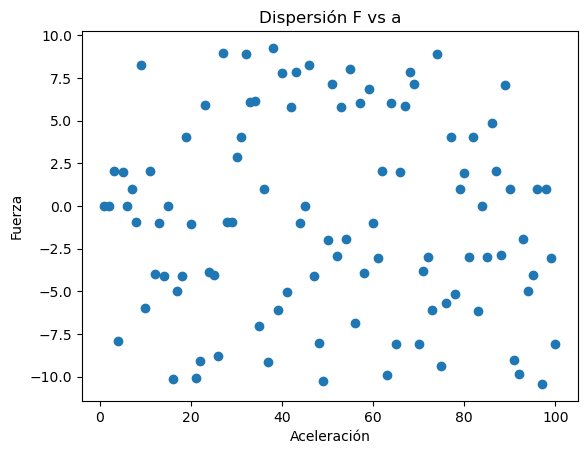

In [22]:
plt.scatter(Nk,a)
plt.xlabel('Aceleración')
plt.ylabel('Fuerza')
plt.title('Dispersión F vs a')
plt.show()

In [19]:
data = {'F':F,'a':a}
df = pd.DataFrame(data)
df.to_csv('data\clase_01.csv',index = False)